## Training a convolutional neural network and transfer learning

In this lab, we will use Keras to train a classifier to classify images between 257 different classes. Here, you will apply the concepts you have been introduced to during our last class. After this laboratory, you should be familiar with the preparation of an image dataset, data augmentation, modeling and training a convolutional neural network, applying transfer learning to it, and using inference to classify images using it.

## The dataset

The dataset is the [CalTech 256 collection](http://www.vision.caltech.edu/Image_Datasets/Caltech256/). This dataset consists of 30607 images, separated into 256 different categories. It is already downloaded for you, for convenience.

In [2]:
import os

# Location of the dataset
dataset_path = 'dataset/'

# Check if dataset exists
if os.path.isdir(dataset_path):
    print("Dataset seems to be ok :D")
else:
    print("Dataset was not found. Please make sure to extract the caltech 257 dataset in the correct folder")    

Dataset seems to be ok :D


There are a few steps that we must follow before feeding this dataset to a neural network. If you check the dataset, you will notice that it is not separated into training, test, and validation datasets. We will also need to resize all of the images to 224x224, annotate the classes inside our dataset, and apply augmentation to our training dataset. 

### Splitting the dataset

To do this, we will use the [split folders package](https://pypi.org/project/split-folders/), which makes this job a lot easier.

In [2]:
import split_folders
import shutil

# If any leftovers from the split folders script exists, let's delete them to avoid flooding our HD with unecessary files.
if os.path.isdir(dataset_path + "test"):
    shutil.rmtree(dataset_path + "test")

if os.path.isdir(dataset_path + "val"):
    shutil.rmtree(dataset_path + "val")

if os.path.isdir(dataset_path + "train"):
    shutil.rmtree(dataset_path + "train")
    
# Let's separate our dataset into test, training, and validation datasets.
split_folders.ratio(dataset_path, output=dataset_path, seed=1337, ratio=(.8, .1, .1)) # default values

Copying files: 30608 files [00:54, 560.47 files/s]


### Data Augmentation

Augmenting data means artificially increasing the number of images inside our dataset. As a general rule, the more data, the better. We do this by flipping, zooming, and cropping the images inside our training dataset. We do not augment our other datasets because we want to generate more data for our model to train on, and not more data to test our model.

In [3]:
# Now let's define our generators and apply augmentation only to the training dataset.

from keras.preprocessing.image import ImageDataGenerator

classes =  tuple(element.strip() for element in open('classes.txt', 'r'))

# We are using these dimensions for the input images because the resNet network was origininally trained with images of this size.
IMAGE_WIDTH, IMAGE_HEIGHT = 224,224
BATCH_SIZE = 64

training_data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

# Data preparation
training_generator = training_data_generator.flow_from_directory(
    dataset_path + "train",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    classes=classes,
    class_mode="categorical")
validation_generator = validation_data_generator.flow_from_directory(
    dataset_path + "val",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    classes=classes,
    class_mode="categorical")
test_generator = test_data_generator.flow_from_directory(
    dataset_path + "test",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    classes=classes,
    class_mode="categorical", 
    shuffle=False)

Found 24385 images belonging to 257 classes.
Found 2963 images belonging to 257 classes.
Found 3259 images belonging to 257 classes.


### Transfer learning

We are using the ResNet50 model as our pre-trained model for the feature extraction. The transfer learning implementation begins by removing the last predicting layer of the resNet model and replacing it with our own predicting layers. 

We freeze the layers inside the resnet50 model by setting the trainable parameter to false. We do not want to train the ResNet layers, because the whole purpose of transfer learning is to use the weights that are already trained for us in this model in the previous dataset, which is imagenet.

Our fully connected layer has 257 nodes because we want to classify our images between 257 classes that come from the Caltech dataset. We use softmax as our activation function because we want to give all of the possible classes a score, and the highest score will be our predicted class.

In [4]:
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Flatten
import keras

from keras.applications.inception_resnet_v2 import InceptionResNetV2
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,3))

top_model = base_model.output
top_model = Flatten()(top_model)
top_model = Dense(1024, activation='relu')(top_model)
predictions = Dense(257, activation='softmax')(top_model)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

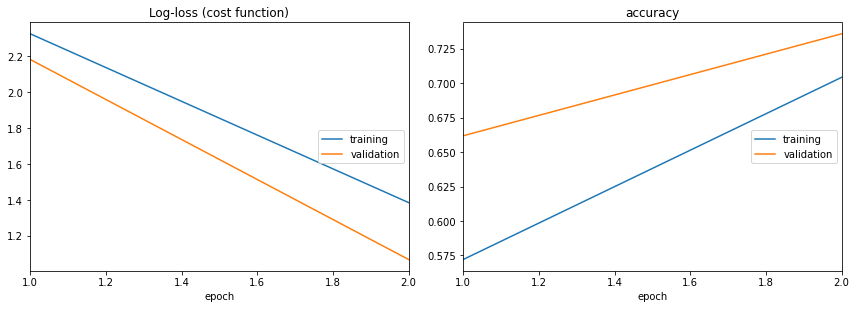

Log-loss (cost function):
training   (min:    1.384, max:    2.324, cur:    1.384)
validation (min:    1.068, max:    2.181, cur:    1.068)

accuracy:
training   (min:    0.572, max:    0.704, cur:    0.704)
validation (min:    0.662, max:    0.736, cur:    0.736)


In [7]:
from livelossplot.keras import PlotLossesCallback

# Training
model.fit_generator(
    training_generator,
    steps_per_epoch=100,
    epochs=2,
    validation_data=validation_generator,
    validation_steps=100,
    callbacks=[PlotLossesCallback()], 
    verbose=1)
model.save_weights('models/caltech-256.h5')


## The predict function

Now let's build our predict function and use it to classify some images! Even though we have some images inside our test dataset to test our model, we can use some images outside the Caltech dataset to make things more fun!

There are some images inside the images-outside-dataset folder that we will use to test our model, but feel free to use your own images as well!

*The images used in the example below were taken from [unsplash](https://unsplash.com/)*

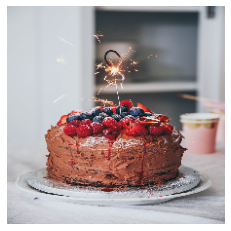

I am 68.45% sure that it belongs to 026.cake.
I am 30.18% sure that it belongs to 206.sushi.


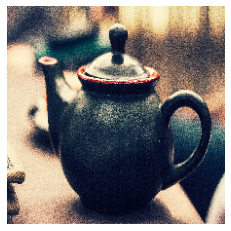

I am 99.97% sure that it belongs to 212.teapot.
I am 0.01% sure that it belongs to 010.beer-mug.


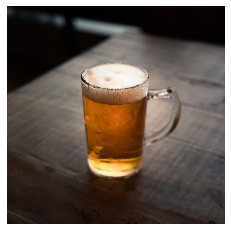

I am 100.00% sure that it belongs to 010.beer-mug.
I am 0.00% sure that it belongs to 059.drinking-straw.


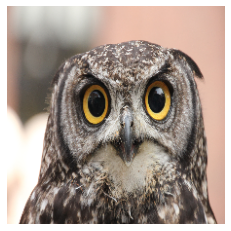

I am 100.00% sure that it belongs to 152.owl.
I am 0.00% sure that it belongs to 117.ipod.


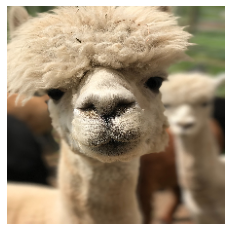

I am 100.00% sure that it belongs to 134.llama-101.
I am 0.00% sure that it belongs to 236.unicorn.


In [8]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

def predict(image): 
   
    prediction1 = model.predict(image)
    # sorting the predictions in descending order
    sorting = (-prediction1).argsort()

    # getting the top 2 predictions
    sorted_ = sorting[0][:2]

    for value in sorted_:
        # you can get your classes from the encoder(your_classes = encoder.classes_) 
        # or from a dictionary that you created before.
        # And then we access them with the predicted index.
        predicted_label = classes[value]

        # just some rounding steps
        prob = (prediction1[0][value]) * 100
        prob = "%.2f" % round(prob,2)
        print("I am %s%% sure that it belongs to %s." % (prob, predicted_label))

        
image1 = load_image("images-outside-dataset/the-cake-is-a-lie.jpg", True)
predict(image1)

image2 = load_image("images-outside-dataset/i-am-a-teapot.jpg", True)
predict(image2)

image3 = load_image("images-outside-dataset/beer.jpg", True)
predict(image3)

image4 = load_image("images-outside-dataset/owl.jpg", True)
predict(image4)

image5 = load_image("images-outside-dataset/llama.jpg", True)
predict(image5)